# Structure analysis for the AIMD
This notebook is intended as a platform for developing the AIMD data analysis. The main components are the use in the MDanalysis package and DScribe

## The MDanalysis package
This is a package containing many, many useful analysis tools for structure, diffusion constants etc from AIMD simulations. Here I will just introduce some easy to use tools. Before starting, you should have MDanalysis installed. For instructions on installation etc, see [the webpage](https://userguide.mdanalysis.org/1.0.0/installation.html).

### Importing MDanalysis
First load the needed dependencies

In [54]:
import MDAnalysis as mda
from ase import *
from ase.io import *
from MDAnalysis.analysis.base import (AnalysisBase,
                                      AnalysisFromFunction,
                                      analysis_class)
from MDAnalysis.analysis import rms
from MDAnalysis.analysis import align
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



Next load the structure and set the timestep

In [55]:
dt = 0.02 #in ps
u = mda.Universe('AuH2O.xyz', dt=dt)
#print(u.atoms.masses)
#print('Number of frames in trajectory:', len(u.trajectory))
#print(len(u.atoms))

Next, choose the atoms you want. We are only interested in the metal atoms.

In [56]:
atoms = u.atoms[48:]
#atoms.masses

Next, loop of over the trajectories to do some sweet, sweet analysis. 

In [57]:
first_pos = u.trajectory[0].positions[48:].copy() # first frame positions, copy needed!
rmsds = []
for ts in u.trajectory[1:20]:
    #print(first_pos - ts.positions[48:])
    rmsds.append(rms.rmsd(first_pos, ts.positions[48:]))
times = np.arange(0,len(rmsds)*dt,dt)
#print(rmsds)
    

Next, plot the rmsds vs time.

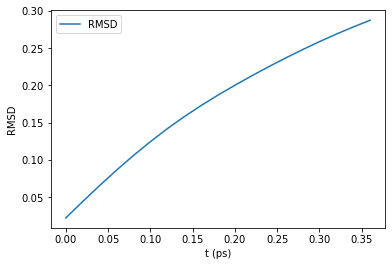

In [66]:
plt.plot(times,rmsds,label='RMSD')
plt.xlabel('t (ps)')
plt.ylabel('RMSD')
plt.legend()
plt.show()

# The PyScal package
While the MDanalysis is great for analyzing RMDS or correlation functions, the PyScal offers the possibility to compute order parameters. In particular, the Steinhardr order parameters are used to differentiate between the crystalline phases of materials - this is what is done herein. Have a look at the [the webpage](http://pyscal.com/en/latest/).

First load all the needed packages and structures.

In [59]:
import pyscal.core as pc
import pyscal.crystal_structures as pcs
import numpy as np
import matplotlib.pyplot as plt


# Make the ideal FCC structures of Pt and Rh
Rh_atoms, Rh_box = pcs.make_crystal('fcc', lattice_constant=3.80, repetitions=[4,4,4])
Rh = pc.System()
Rh.atoms = Rh_atoms
Rh.box = Rh_box

Pt_atoms, Pt_box = pcs.make_crystal('bcc', lattice_constant=3.92, repetitions=[4,4,4])
Pt = pc.System()
Pt.atoms = Pt_atoms
Pt.box = Pt_box

Next, compute the radial distribution functions to choose the cutoff radii. Plot the RDFs.


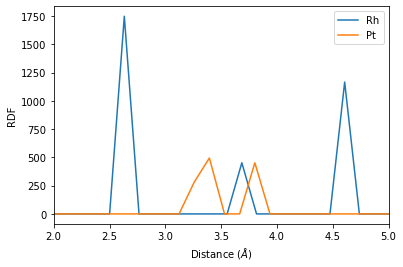

In [60]:
Rh_RDF = Rh.calculate_rdf()
Pt_RDF = Pt.calculate_rdf()
plt.plot(Rh_RDF[1], Rh_RDF[0], label='Rh')
plt.plot(Pt_RDF[1], Pt_RDF[0], label='Pt')
plt.xlabel(r'Distance ($\AA$)')
plt.ylabel('RDF')
plt.xlim([2,5])
plt.legend()
plt.show()

### Steinhardt parameters

We can choose the mid-point between the nearest and 2nd nearest neighbors as the cut-off distance. These cutoffs are then used for computing the the number of nearest neighbors and the Steinhardt parameters for both the perfect bulk and the actual clusters.

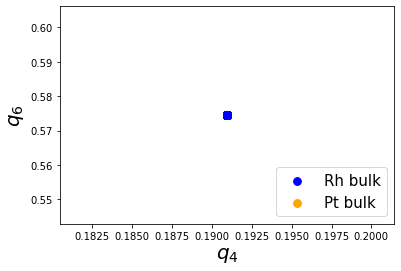

In [61]:
Pt.find_neighbors(method='cutoff', cutoff=3.3)
Rh.find_neighbors(method='cutoff', cutoff=3.3)
print(Pt)
#Steinhardt q4 and q6
Pt.calculate_q([4,6])
Rh.calculate_q([4,6])
Pt_q = Pt.get_qvals([4, 6])
Rh_q = Rh.get_qvals([4, 6])
plt.scatter(Rh_q[0], Rh_q[1], s=60, label='Rh bulk', color='blue')

    
Pt.calculate_q([4,6])
plt.scatter(Pt_q[0], Pt_q[1], s=60, label='Pt bulk', color='orange')
plt.xlabel("$q_4$", fontsize=20)
plt.ylabel("$q_6$", fontsize=20)
plt.legend(loc=4, fontsize=15)

Having the bulk values set, lets look at the clusters and repeate the same. We loop of the structures, collect the q-values and plot with colors presenting the time.

/Users/mamimela/git/production/ase/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


black
orange
red


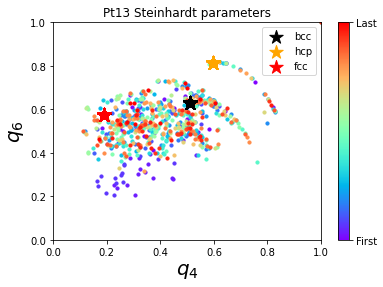

In [62]:
# Fetch files
from os import listdir
from os.path import isfile, join
from pyscal.traj_process import *

from ase.io import read
from matplotlib import cm
data = [f for f in listdir('/Users/mamimela/Desktop/andrey_60/Pt13') if 
            isfile(join('/Users/mamimela/Desktop/andrey_60/Pt13', f))]

read('/Users/mamimela/Desktop/andrey_60/Pt13/%s'%data[0])

cmap = 'rainbow'
# Choose the color map
colors = cm.get_cmap(cmap, len(data))
# Choose is color uniquely
color_index = np.linspace(0, 1, len(data))


for i in range(len(data)):
    # Read from using ASE
    cluster = read('/Users/mamimela/Desktop/andrey_60/Pt13/%s'%data[i])
    
    # Remove support
    cluster = cluster[216:]
    
    # Read ASE object in Pyscal
    cluster_p = read_ase(cluster)
    
    # Make into Pyscal System
    cluster_sys = pc.System()
    cluster_sys.atoms = cluster_p[0] 
    
    # Do Steinhardt
    cluster_sys.find_neighbors(method='cutoff', cutoff=3.3)
    cluster_sys.calculate_q([4,6])
    cluster_q = cluster_sys.get_qvals([4, 6])
    plt.scatter(cluster_q[0], cluster_q[1], s=10, color=colors(color_index[i]))

    
# Add also BCC and HCP points
for t, c, o in zip(['bcc','hcp','fcc'], ['black','orange','red'], [4,3,4]):
    atoms, box = pcs.make_crystal(t, lattice_constant=o, repetitions=[4,4,4])
    A = pc.System()
    A.atoms = atoms
    A.box = box
    A.find_neighbors(method='cutoff', cutoff=o)
    A.calculate_q([4,6])
    a_q = A.get_qvals([4, 6])
    plt.scatter(a_q[0], a_q[1], s=200, label=t, color=c, marker='*')
    print(c)
    
# Set colorbar
cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap), ticks=[0, 1])
cbar.ax.set_yticklabels(['First', 'Last'])

plt.legend()
#Finalize plotting
plt.xlabel("$q_4$", fontsize=20)
plt.ylabel("$q_6$", fontsize=20)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Pt13 Steinhardt parameters')
    
    
plt.show()


How to interpret this? The local structures resembling BCC, FCC, and HCP phases are marked in the figure. More generally, fully disoriented liquids have $q_4\approx q_6 \approx 0$. So it seems that the studied clusters in the example are not liquid-like but have some crystallinity. There's a lot of scatter in the data and the structure clearly evolves. We can also have a look at just some individual atom to see how it behavior changes in time. For instance, we can take an atom in the center of the cluster and some atom at the edge. Let's have a look...

Text(0.5, 1.0, 'Pt13 Steinhardt parameters')

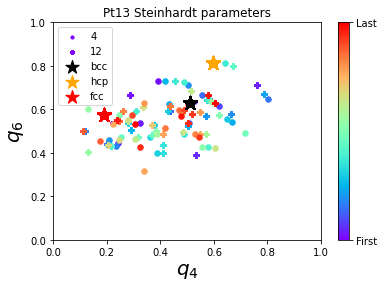

In [63]:
chosen_atoms = [4,12]
markers = ['o', 'P']
points = []
for i in range(len(data)):
    # Read from using ASE
    cluster = read('/Users/mamimela/Desktop/andrey_60/Pt13/%s'%data[i])
    
    # Remove support
    cluster = cluster[216:]
    
    # Read ASE object in Pyscal
    cluster_p = read_ase(cluster)
    
    # Make into Pyscal System
    cluster_sys = pc.System()
    cluster_sys.atoms = cluster_p[0] 
    
    # Do Steinhardt
    cluster_sys.find_neighbors(method='cutoff', cutoff=3.3)
    cluster_sys.calculate_q([4,6])
    cluster_q = cluster_sys.get_qvals([4, 6])
    
    for m,j in enumerate(chosen_atoms):
        if i == 0: # set labels only once. There needs to be a better way for this...
            plt.scatter(cluster_q[0][j], cluster_q[1][j], s=10, 
                    color=colors(color_index[i]), marker=markers[m],
                    label='%s'%j)
        else:
            plt.scatter(cluster_q[0][j], cluster_q[1][j], s=30, 
                    color=colors(color_index[i]), marker=markers[m])
        points.append(cluster_q[0][j])

# Add also BCC and HCP points
for t, c, o in zip(['bcc','hcp'], ['black','orange'], [4,3]):
    atoms, box = pcs.make_crystal(t, lattice_constant=o, repetitions=[4,4,4])
    A = pc.System()
    A.atoms = atoms
    A.box = box
    A.find_neighbors(method='cutoff', cutoff=o)
    A.calculate_q([4,6])
    a_q = A.get_qvals([4, 6])
    plt.scatter(a_q[0], a_q[1], s=200, label=t, color=c, marker='*')

    
# Set colorbar
cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap), ticks=[0, 1])
cbar.ax.set_yticklabels(['First', 'Last'])

plt.scatter(Rh_q[0], Rh_q[1], s=200, label='fcc', color='red', marker='*')
plt.legend()
#Finalize plotting
plt.xlabel("$q_4$", fontsize=20)
plt.ylabel("$q_6$", fontsize=20)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Pt13 Steinhardt parameters')

This shows how even just one atom in both the center (4) and edge (12) changes its characteristics depending on the specific geometry.

### The averaged Steinhardt parameters
Above the normal Steinhardt parameters were computed but more information can be obtained by looking at the averaged version of this parameter as shown [Lechner and Dellago](https://doi.org/10.1063/1.2977970). This extension goes beyond the first coordination sphere and hence provides more information about the local environment. To compute these averages, only slight modifications are needed.

black
orange
red


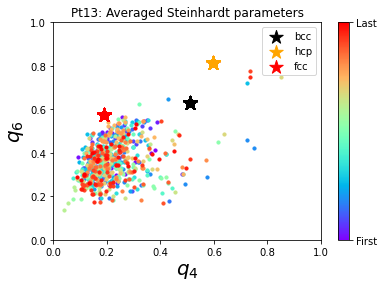

In [64]:
for i in range(len(data)):
    # Read from using ASE
    cluster = read('/Users/mamimela/Desktop/andrey_60/Pt13/%s'%data[i])
    
    # Remove support
    cluster = cluster[216:]
    
    # Read ASE object in Pyscal
    cluster_p = read_ase(cluster)
    
    # Make into Pyscal System
    cluster_sys = pc.System()
    cluster_sys.atoms = cluster_p[0] 
    
    # Do Steinhardt
    cluster_sys.find_neighbors(method='cutoff', cutoff=3.3)
    cluster_sys.calculate_q([4,6], averaged=True)
    cluster_q = cluster_sys.get_qvals([4, 6], averaged=True)
    plt.scatter(cluster_q[0], cluster_q[1], s=10, color=colors(color_index[i]))

    
# Add also BCC and HCP points
for t, c, o in zip(['bcc','hcp','fcc'], ['black','orange','red'], [4,3,4]):
    atoms, box = pcs.make_crystal(t, lattice_constant=o, repetitions=[4,4,4])
    A = pc.System()
    A.atoms = atoms
    A.box = box
    A.find_neighbors(method='cutoff', cutoff=o)
    A.calculate_q([4,6], averaged=True )
    a_q = A.get_qvals([4, 6], averaged=True)
    plt.scatter(a_q[0], a_q[1], s=200, label=t, color=c, marker='*')
    print(c)
    
# Set colorbar
cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap), ticks=[0, 1])
cbar.ax.set_yticklabels(['First', 'Last'])

plt.legend()
#Finalize plotting
plt.xlabel("$q_4$", fontsize=20)
plt.ylabel("$q_6$", fontsize=20)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Pt13: Averaged Steinhardt parameters')
    
    
plt.show()

Interesting... Still $q_4\approx q_6$ but the structures are now classified as liquid-like!

# The ASAP package
Machine learning is very fashionable so we'll use it as well. The ASAP package contains methods for making various analyzing structures based on presentations or fingerprints of the atomic environments. Here we will use the SOAP method to generate the fingerprints. These will be given as SOAP vectors which can the be used the analysis either in terms of principal components or distance metrics. 